# LSST Simulation generation
This notebook is a wrapper for StarFast, which generates simulated images with realistic stellar distributions and spectra, psf and filters, and detailed atmospheric differential chromatic refraction (DCR)

In [1]:
import os
import imp
import numpy as np
import pickle
import galsim
from lsst.afw.geom import Angle

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from matplotlib import pylab as plt
import lsst.afw.display.rgb as rgb

In [3]:
def ramp_distribution(rng, x0, x1, x2, invert=True):
    # A distribution with a linear increase in probability up to a point, and flat after that
    # The probability of measuring x' < x is P(x'<x) = Integral{x0,x: c1*x dx}
    # if x is greater than x1, the probability is P(x' < x) = P(x' < x1) + Integral(x1,x: c2 dx)
    # The probability of measuring less than x2 is 1.0, and c1*x1 = c2, which allows us to solve for c1:
    c1 = 1./(x1*x2 - (x0**2. + x1**2.)/2.)
    p1 = c1*(x1**2. - x0**2.)/2.
    if invert:
        # Calculate x from P(x)
        p = rng.rand()
        if p <= p1:
            x = np.sqrt(2.*p/c1 + x0**2.)
        else:
            x = (p - p1)/(c1*x1) + x1
        return((p, x))
    else:
        # Calculate P(x) from x
        x = rng.rand()*(x2 - x0) + x0
        if x <= x1:
            p = c1*(x**2. - x0**2.)/2.
        else:
            p = p1 + c1*x1*(x - x1)
        return((x, p)) 

Text(0,0.5,'elevation')

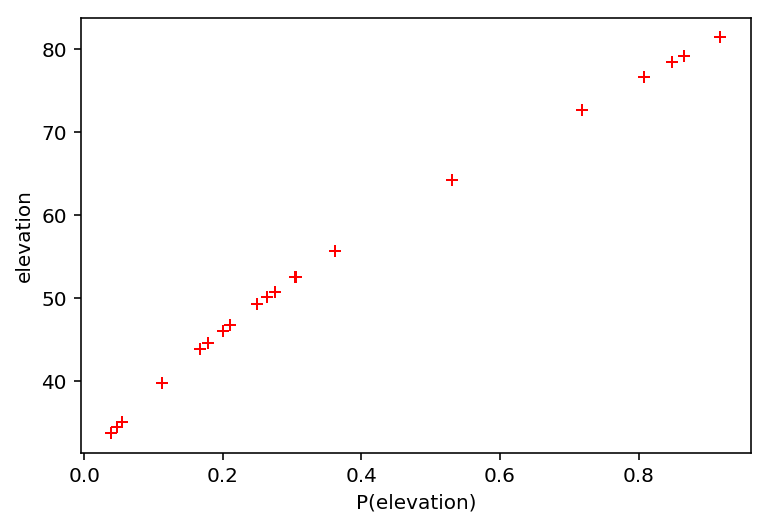

In [4]:
rng1 = np.random.RandomState(15)
el1 = []
prob1 = []
air1 = []
for _i in range(20):
    vals = ramp_distribution(rng1, 30., 70., 85.)
    _elevation = vals[1]
    _airmass = 1./np.cos((90. - _elevation)*np.pi/180.)
    prob1.append(vals[0])
    air1.append(_airmass)
    el1.append(_elevation)
plt.plot(prob1, el1,'r+')
plt.xlabel('P(elevation)')
plt.ylabel('elevation')

In [5]:
def quad_distribution(rng, x0, x1, x2, invert=True):
    # As the ramp_distribution, but now the probability distribution increases quadratically from 0 between x0 and x1
    c1 = 1./((x1**3. - x0**3.)/3. + x1**2.*(x2 - x1))
    p1 = c1*(x1**3. - x0**3.)/3.
    if invert:
        # Calculate x from P(x)
        p = rng.rand()
        if p <= p1:
            x = (3.*p/c1 + x0**3.)**(1./3.)
        else:
            x = (p - p1)/(c1*x1**2.) + x1
        return((p, x))
    else:
        # Calculate P(x) from x
        x = rng.rand()*(x2 - x0) + x0
        if x <= x1:
            p = c1*(x**3. - x0**3.)/3.
        else:
            p = p1 + c1*x1*2.*(x - x1)
        return((x, p))

Text(0,0.5,'elevation')

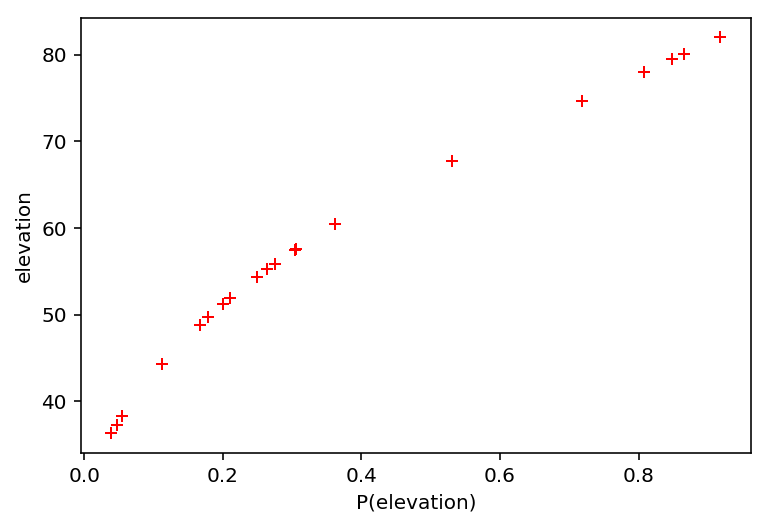

In [6]:
rng2 = np.random.RandomState(15)
el2 = []
prob2 = []
air2 = []
for _i in range(20):
    vals = quad_distribution(rng2, 30., 70., 85.)
    _elevation = vals[1]
    _airmass = 1./np.cos((90. - _elevation)*np.pi/180.)
    prob2.append(vals[0])
    air2.append(_airmass)
    el2.append(_elevation)
plt.plot(prob2, el2,'r+')
plt.xlabel('P(elevation)')
plt.ylabel('elevation')

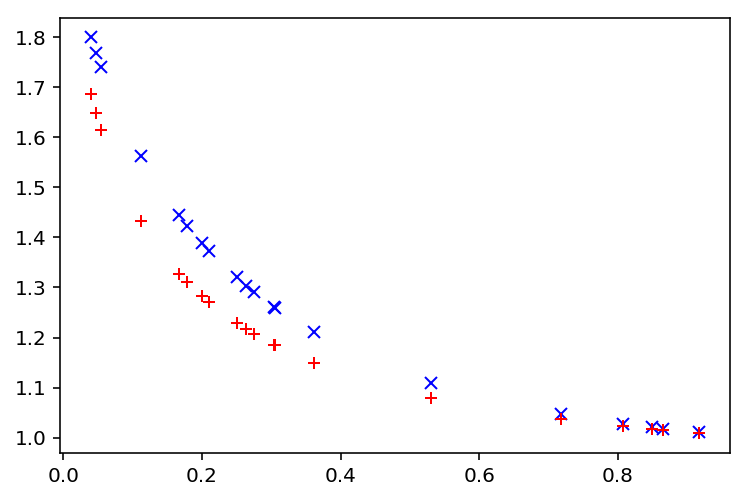

In [7]:
plt.plot(prob1, air1,'bx')
plt.plot(prob2, air2,'r+')

In [8]:
rng = np.random.RandomState(15)
rand_test = []
for _i in range(100):
    rand_test.append(np.abs(0.5*rng.randn()))

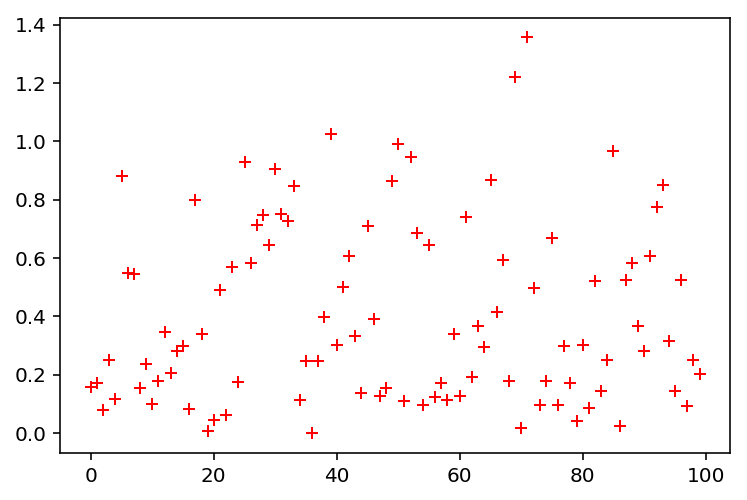

In [9]:
plt.plot(rand_test, 'r+')

In [10]:
n_exp = 24
expId0 = 100
elevation_min = 30.
elevation_flat = 70.
elevation_max = 85.
rng = np.random.RandomState(15)
az = []
el = []
airmasses = []
for expId in range(expId0, expId0 + n_exp):
    azimuth = rng.rand()*360.
    elevation = quad_distribution(rng, elevation_min, elevation_flat, elevation_max)[1]
    az.append(azimuth)
    el.append(elevation)
    _airmass = 1./np.cos((90 - elevation)*np.pi/180.)
    airmasses.append(_airmass)

In [11]:
# from lsst.sims.photUtils import matchStar

imp.load_source('calc_refractive_index', '/Users/sullivan/LSST/code/StarFast/calc_refractive_index.py')
imp.load_source('fast_dft', '/Users/sullivan/LSST/code/StarFast/fast_dft.py')
imp.load_source('StarFast', '/Users/sullivan/LSST/code/StarFast/StarFast.py')
from StarFast import StarSim

lsst_lat = Angle(np.radians(-30.244639))
lsst_lon = Angle(np.radians(-70.749417))
lsst_alt = 2663.

Set up the general parameters to use for all of the simulations 

In [27]:
seed = 8  # Seed for the random number generator. Simulations with the same seed are reproduceable
dimension = 1024  # Number of pixels on a side for the simulated image
n_star = 10000  # Number of stars to model in the simulated catalog.
# The catalog covers an area ~4x larger than the area, to allow simulated rotations and dithering observations
pixel_scale = 0.25  # plate scale, in arcseconds/pixel
hottest_star = 'B'  # Hottest star to include (types are 'OBAFGKMR')
coolest_star = 'M'  # Coolest star to include
wavelength_step = 10  # Wavelength resolution of the spectra and calculation of filter and DCR effects. In nm.
ra_offset = Angle(0)  # Additional offset in RA from the field center, for dithering. In radians as an LSST Angle object
dec_offset = Angle(0)  # Additional offset in Dec from the field center, for dithering. In radians as an LSST Angle object
sky_rotation = 0.0  # Sky rotation angle, in Degrees. I realize this is different than RA and Dec
exposureId = 0  # Unique exposure identification number. Also used as the "OBSID"
instrument_noise = 0.  # Adds noise akin to instrumental noise (post-PSF). Set to 1.0 for default value, can be scaled up or down
photon_noise = 1./15.  # Adds poisson noise akin to photon shot noise. Set to 1.0 for default value, can be scaled up or down
sky_noise = 0  # Adds noise prior to convolving with the PSF.
output_directory = "/Users/sullivan/LSST/simulations/test%1i_variablePSF/" % seed  # Path to the directory to save output
band_dict = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}  # LSST filter numbers used by the butler

In [35]:
# The "base" PSF is used, e.g.,  for setting the buffer size to avoided sources right at the edge
# It should be larger than most PSFs used
psf_fwhm_min = 0.25 - 0.0625
psf_fwhm_base = 0.75  # FWHM of the PSF, in arcseconds
psf_fwhm_variance = 0.125

In [29]:
attenuation = 20. # attenuation factor that was used in the simulations

In [30]:
ra = lsst_lon + ra_offset
dec = lsst_lat + dec_offset

Load simulated Kurucz stellar SEDs. Cache the list for later use.

In [31]:
pickle_file = "sed_list.pickle"
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as dumpfile:
        sed_list = pickle.load(dumpfile)
else:
    matchStarObj = matchStar()
    sed_list = matchStarObj.loadKuruczSEDs()
    with open(pickle_file, 'wb') as dumpfile:
        pickle.dump(sed_list, dumpfile)

Set up the PSF.

In [36]:
gsp = galsim.GSParams(folding_threshold=1.0 / (dimension), maximum_fft_size=12288)
psf_base = galsim.Kolmogorov(fwhm=psf_fwhm_base / pixel_scale, flux=1, gsparams=gsp)

# g-band simulation

In [18]:
band_name = 'g'

In [19]:
use_bp = True
sim = StarSim(psf=psf_base, pixel_scale=pixel_scale, x_size=dimension, y_size=dimension,
              band_name=band_name, wavelength_step=wavelength_step,
              sed_list=sed_list, ra=ra, dec=dec, sky_rotation=sky_rotation,
              use_mirror=use_bp, use_lens=use_bp, use_atmos=use_bp,
              use_filter=use_bp, use_detector=use_bp, attenuation=attenuation)

Simulate a catalog of stars, with fluxes and SEDs

In [20]:
sim.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)

Number and flux contribution of stars of each type:
 [M 7745| 1.21%] [K 1164| 1.99%] [G 716| 2.45%] [F 300| 3.59%] [A 62| 9.34%] [B 13| 81.42%] [O 0| 0.00%]


Generate the raw simulation

In [21]:
sim.make_reference_catalog(output_directory=output_directory + "input_data/", filter_list=['g'], magnitude_limit=16.0)

Writing 695 stars brighter than 16.0 mag to reference catalog in 1 bands
Min/max magnitude:  5.724159303122955 22.49404801300464


In [22]:
sim.simulate()

Simulating 2428 stars within observable region
Time to model 2421 stars: [39.672s | 0.01639s per star]
Time to model 7 bright stars: [4.945s | 0.70650s per star]


In [34]:
n_exp = 24

In [37]:
expId0 = exposureId + 100*band_dict[band_name]
elevation_min = 30.
elevation_flat = 70.
elevation_max = 85.
rng = np.random.RandomState(15)
for expId in range(expId0, expId0 + n_exp):
    azimuth = 0 if rng.rand() < 0.5 else 180.
    elevation = quad_distribution(rng, elevation_min, elevation_flat, elevation_max)[1]
    psf_fwhm_use = psf_fwhm_min + np.abs(psf_fwhm_variance*rng.randn())
    psf = galsim.Kolmogorov(fwhm=psf_fwhm_use/pixel_scale, flux=1, gsparams=gsp)
    exposure = sim.convolve(elevation=elevation, azimuth=azimuth,
                            instrument_noise=instrument_noise, sky_noise=sky_noise,
                            photon_noise=photon_noise, exposureId=expId, obsid=expId,
                            psf=psf)
    filename = "lsst_e_%3.3i_f%i_R22_S11_E000.fits" % (expId, band_dict[band_name])
    exposure.writeFits(output_directory + "images/" + filename)

FFT timing for 15 DCR planes: [2.194s | 0.146s per plane]
FFT timing for 15 DCR planes: [8.169s | 0.545s per plane]
FFT timing for 15 DCR planes: [1.741s | 0.116s per plane]
FFT timing for 15 DCR planes: [7.027s | 0.468s per plane]
FFT timing for 15 DCR planes: [1.853s | 0.124s per plane]
FFT timing for 15 DCR planes: [8.211s | 0.547s per plane]
FFT timing for 15 DCR planes: [1.984s | 0.132s per plane]
FFT timing for 15 DCR planes: [8.567s | 0.571s per plane]
FFT timing for 15 DCR planes: [1.923s | 0.128s per plane]
FFT timing for 15 DCR planes: [7.553s | 0.504s per plane]
FFT timing for 15 DCR planes: [1.810s | 0.121s per plane]
FFT timing for 15 DCR planes: [7.372s | 0.491s per plane]
FFT timing for 15 DCR planes: [2.163s | 0.144s per plane]
FFT timing for 15 DCR planes: [7.692s | 0.513s per plane]
FFT timing for 15 DCR planes: [1.960s | 0.131s per plane]
FFT timing for 15 DCR planes: [8.591s | 0.573s per plane]
FFT timing for 15 DCR planes: [2.530s | 0.169s per plane]
FFT timing for